In [31]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.text import Text
import string

In [32]:
#path for FIFI FOI request
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/FIFI_data_through_5-12-19.xlsx'

In [33]:
#original file has multiple sheets (for different FIFI types)
whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()
for sheet_name in whole_file.sheet_names:
    sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name))
    print(sheet_name)
    print(sheet_data.columns.values)
    sheet_data['FIFI_category'] = [sheet_name]*sheet_data.shape[0]
    combined_data = pd.concat([combined_data, sheet_data], sort=False)

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.head(1)

['Abandoned Vehicle', 'Clogged Storm Drain', 'Community Walk', 'Dead Animal', 'Graffiti Report', 'Litter-Illegal Dumping-Needles', 'Overgrown Vegetation', 'Parking Enforcement', 'Pothole', 'Sign and Signal Maintenance', 'Streetlight Report', 'Other Inquiry']
Abandoned Vehicle
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'License Number' 'State' 'Vehicle Make' 'Vehicle Color'
 'Length of Time Parked' 'Photo']
Clogged Storm Drain
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Location Details.1' 'Causing property damage?' 'Photo']
Community Walk
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Current Issue' 'Location Details.1' 'Photo']
Dead Animal
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Type of animal' 'On private property?' 'Photo']
Graffiti Report
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'D

,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13-00064098,2013-08-13 18:05:17,"2629 SW ANDOVER ST, SEATTLE, WA","26012799 SW Andover St, Seattle; XY: 1261975.9...",NaN,Acxo217,NaN,Suzuki,Other,Over 1 Week,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13-00064109,2013-08-13 18:57:44,"402 BELMONT AVE E, SEATTLE, WA","327 Belmont Ave E, Seattle; XY: 1272796.132329...",I don't think this car has been moved in quite...,379 vuq,NaN,Volkswagen,Silver,Over 3 Days,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13-00064128,2013-08-13 20:24:22,"5283 39TH AVE S, SEATTLE, WA","5239 39th Ave S Seattle, WA 98118; XY: 1282330...",Older Honda with flat tire,See photo,NaN,Honda,Blue,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13-00064164,2013-08-14 06:51:34,"4755 38TH AVE SW, SEATTLE, WA","XY: 1258575.3814046786, 207971.16513023284; La...",Green 4 door Volkswagen Golf,WA AGD9667,NaN,Volkswagen,Green,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#select data that includes a zip code (starting with 2015)
combined_data_2015 = combined_data[combined_data['Created Date'].dt.year > 2015]
print(combined_data_2015.shape)
#select FIFI categories that have great than 999 entries
cat_counts = combined_data_2015['FIFI_category'].value_counts()
cat_counts_1000 = cat_counts[cat_counts > 999].index.values
combined_data_final = combined_data_2015[combined_data_2015['FIFI_category'].isin(cat_counts_1000)]
print(combined_data_final['FIFI_category'].value_counts())  
#create new column with zip code
combined_data_final['zip'] = combined_data_final.apply(lambda row: row['Location'].split()[-1], axis=1)    
combined_data_final.head(1)


(204534, 30)
Litter-Illegal Dumping-Needles    45255
Other Inquiry                     41206
Abandoned Vehicle                 29167
Parking Enforcement               26604
Graffiti Report                   24489
Pothole                           19278
Sign and Signal Maintenance       12219
Streetlight Report                 5631
Name: FIFI_category, dtype: int64


,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue,zip
5994,16-00000050,2016-01-01 10:17:27,"5900 34TH CT S, SEATTLE, WA 98118","5900 34TH CT S; XY: 1280854.342623405, 203954....","Gold car, appears to have a window that won't ...",065-XVB,WA,Mercedes-Benz,Other,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98118


In [167]:
zip_neighborhood_dic = {'98028': 'Kenmore', 
                        '98031': 'Kent',
                        '98057': 'Renton',
                        '98101': 'Downtown_FirstH', 
                        '98102': 'Cap_Hill', 
                        '98103': 'GnWd_Frmt_GnLk', 
                        '98104': 'PioneerS_FirstH',
                        '98105': 'Udist_LaHu', 
                        '98106': 'Delridge',
                        '98107': 'Ballard', 
                        '98108': 'South_Park',
                        '98109': 'Westlake',
                        '98112': 'Madison_Park',
                        '98115': 'Wedgewood',
                        '98116': 'WestS_Alki', 
                        '98117': 'Ballard',
                        '98118': 'ColCity_SewardP', 
                        '98119': 'Queen_Anne',
                        '98121': 'Belltown',
                        '98122': 'Leschi',
                        '98125': 'Northgate', 
                        '98126': 'Gatewood',
                        '98133': 'Bitterlake',
                        '98134': 'Harbor_Island',
                        '98136': 'Fauntleroy',
                        '98144': 'MtBaker', 
                        '98146': 'Arbor_Heights',
                        '98148': 'Sunnydale',
                        '98155': 'North_City',
                        '98164': 'Downtown',
                        '98166': 'Gregory_Heights',
                        '98168': 'Burien',
                        '98177': 'LoyalH_Highlands',
                        '98178': 'Lakeridge',
                        '98188': 'SeaTac',
                        '98195': 'U_Dist',
                        '98199': 'Magnolia'}

zip_list = list(zip_neighborhood_dic.keys())
zip_filtered = combined_data_final[combined_data_final['zip'].isin(zip_list)]
print(zip_filtered.shape)

zip_filtered['neighborhood'] = zip_filtered.apply(lambda row: zip_neighborhood_dic[row['zip']], axis=1)

zip_filtered.head(1)

(203775, 31)


,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue,zip,neighborhood
5994,16-00000050,2016-01-01 10:17:27,"5900 34TH CT S, SEATTLE, WA 98118","5900 34TH CT S; XY: 1280854.342623405, 203954....","Gold car, appears to have a window that won't ...",065-XVB,WA,Mercedes-Benz,Other,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98118,ColCity_SewardP


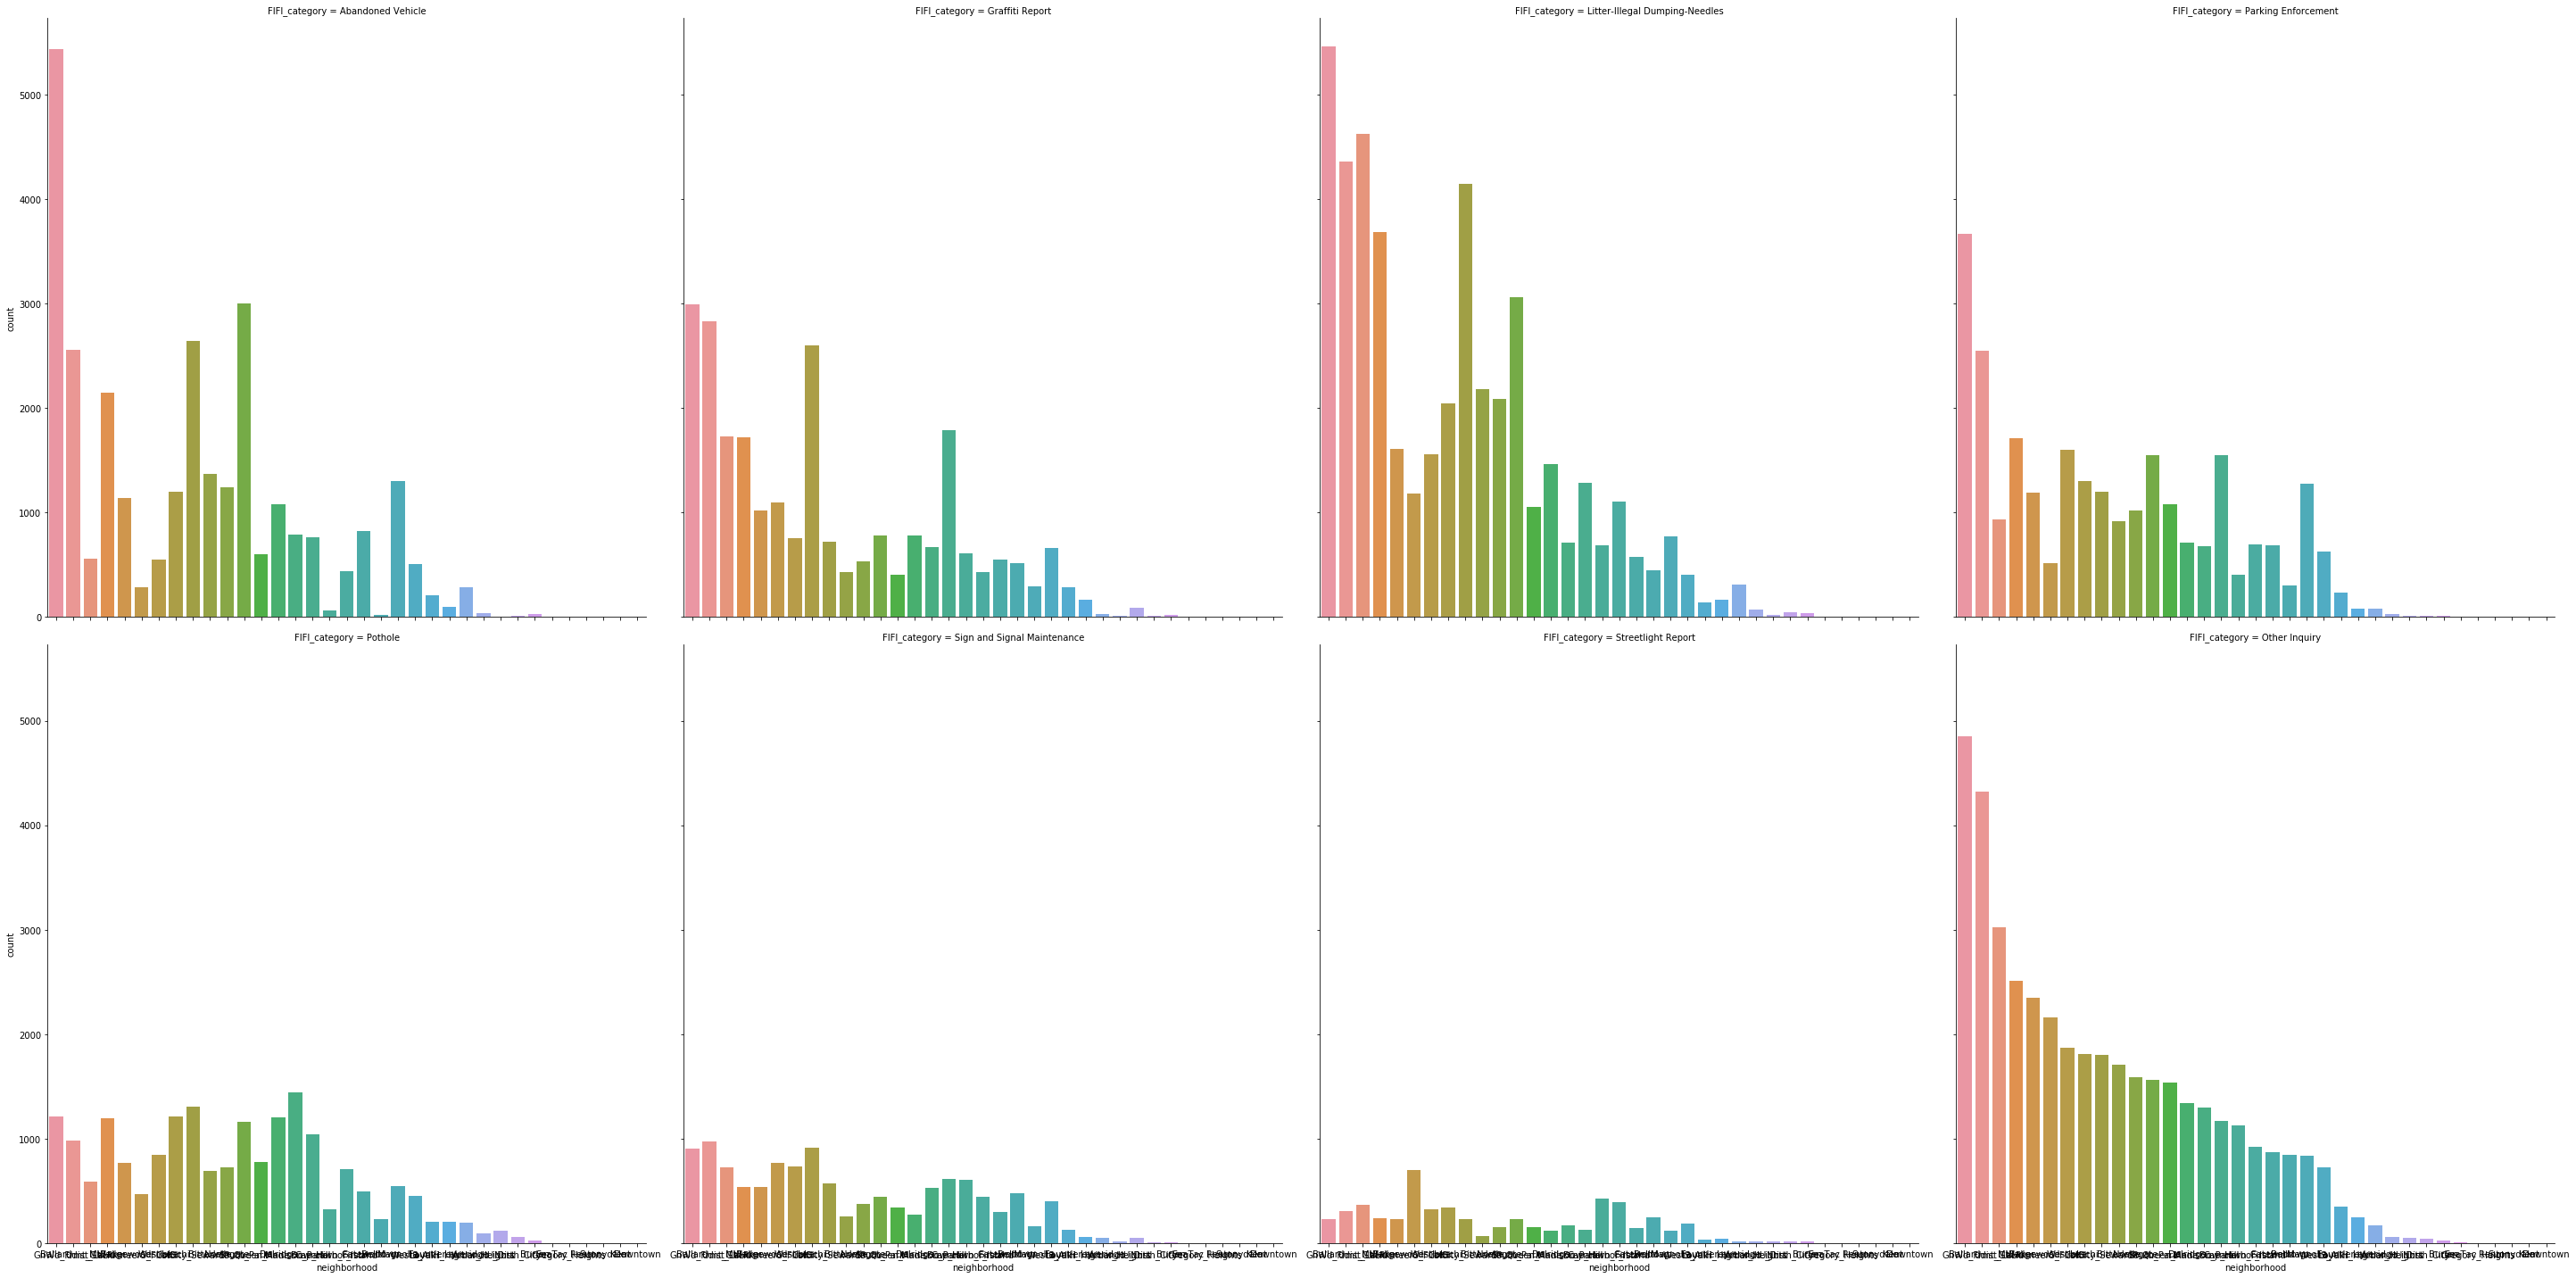

In [73]:
#create count list based on neighborhoods ranked by entries for 'other' category, use to sort graphs
other_highest_neigh = zip_filtered[zip_filtered['FIFI_category'] == 'Other Inquiry'].groupby(['neighborhood'])['neighborhood'].size().reset_index(name='count')
other_highest_neigh = other_highest_neigh.sort_values('count', ascending=False)
other_highest_neigh_list = other_highest_neigh['neighborhood'].values

sns.catplot(x='neighborhood', data=zip_filtered, col='FIFI_category', kind='count', col_wrap=4, height=10, order=other_highest_neigh_list)

In [218]:
#sentiment analysis with nltk

#x = zip_filtered.iloc[5994]['Description']
#print(x)

print(zip_filtered.shape)
zip_filtered_note = zip_filtered[~zip_filtered['Description'].isna()]
print(zip_filtered_note.shape)

#remove punctuation
#x = re.sub(r'[^\w\s]','',x)
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: re.sub(r'[^\w\s]','', row['Description']), axis=1)
#print(x)

#tokenize each entry
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: word_tokenize(row['entry_clean']), axis=1)
#x=word_tokenize(x)
#print(x)

#remove stop words
#stop_words=set(stopwords.words("english"))
#zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: w for w in row['entry_clean'] if w not in stop_words, axis=1)
#x = [w for w in x if w not in stop_words]
#print(x)

# Stemming
#ps = PorterStemmer()
#x = [ps.stem(w) for w in x]
#print(x)

#part of speech assign
#x = nltk.pos_tag(x)
#print(x)

(203775, 32)
(186204, 32)


In [219]:
#use sentiment.vader to get polarity score of each entry
sid = SentimentIntensityAnalyzer()
x_polarity_sum = []
x_polarity_min = []
x_polarity_max = []
for index, row in zip_filtered_note.iterrows():
    polarity_list = [sid.polarity_scores(w)['compound'] for w in row['entry_clean']]
    x_polarity_sum.append(sum(polarity_list))
    try:
        x_polarity_min.append(min(polarity_list))
    except: 
        x_polarity_min.append(np.nan)
    try:
        x_polarity_max.append(max(polarity_list))
    except: 
        x_polarity_max.append(np.nan)
    
#zip_filtered_note['x_polarity'] = zip_filtered_note.apply(lambda row: sid.polarity_scores(w)['compound'] for w in row['entry_clean'], axis=1)
#zip_filtered_note['x_polarity'] = zip_filtered_note.apply(lambda row: sum(row['x_polarity']))
#x_polarity = [sid.polarity_scores(w)['compound'] for w in x]
zip_filtered_note['x_polarity_sum'] = x_polarity_sum
zip_filtered_note['x_polarity_min'] = x_polarity_min
zip_filtered_note['x_polarity_max'] = x_polarity_max

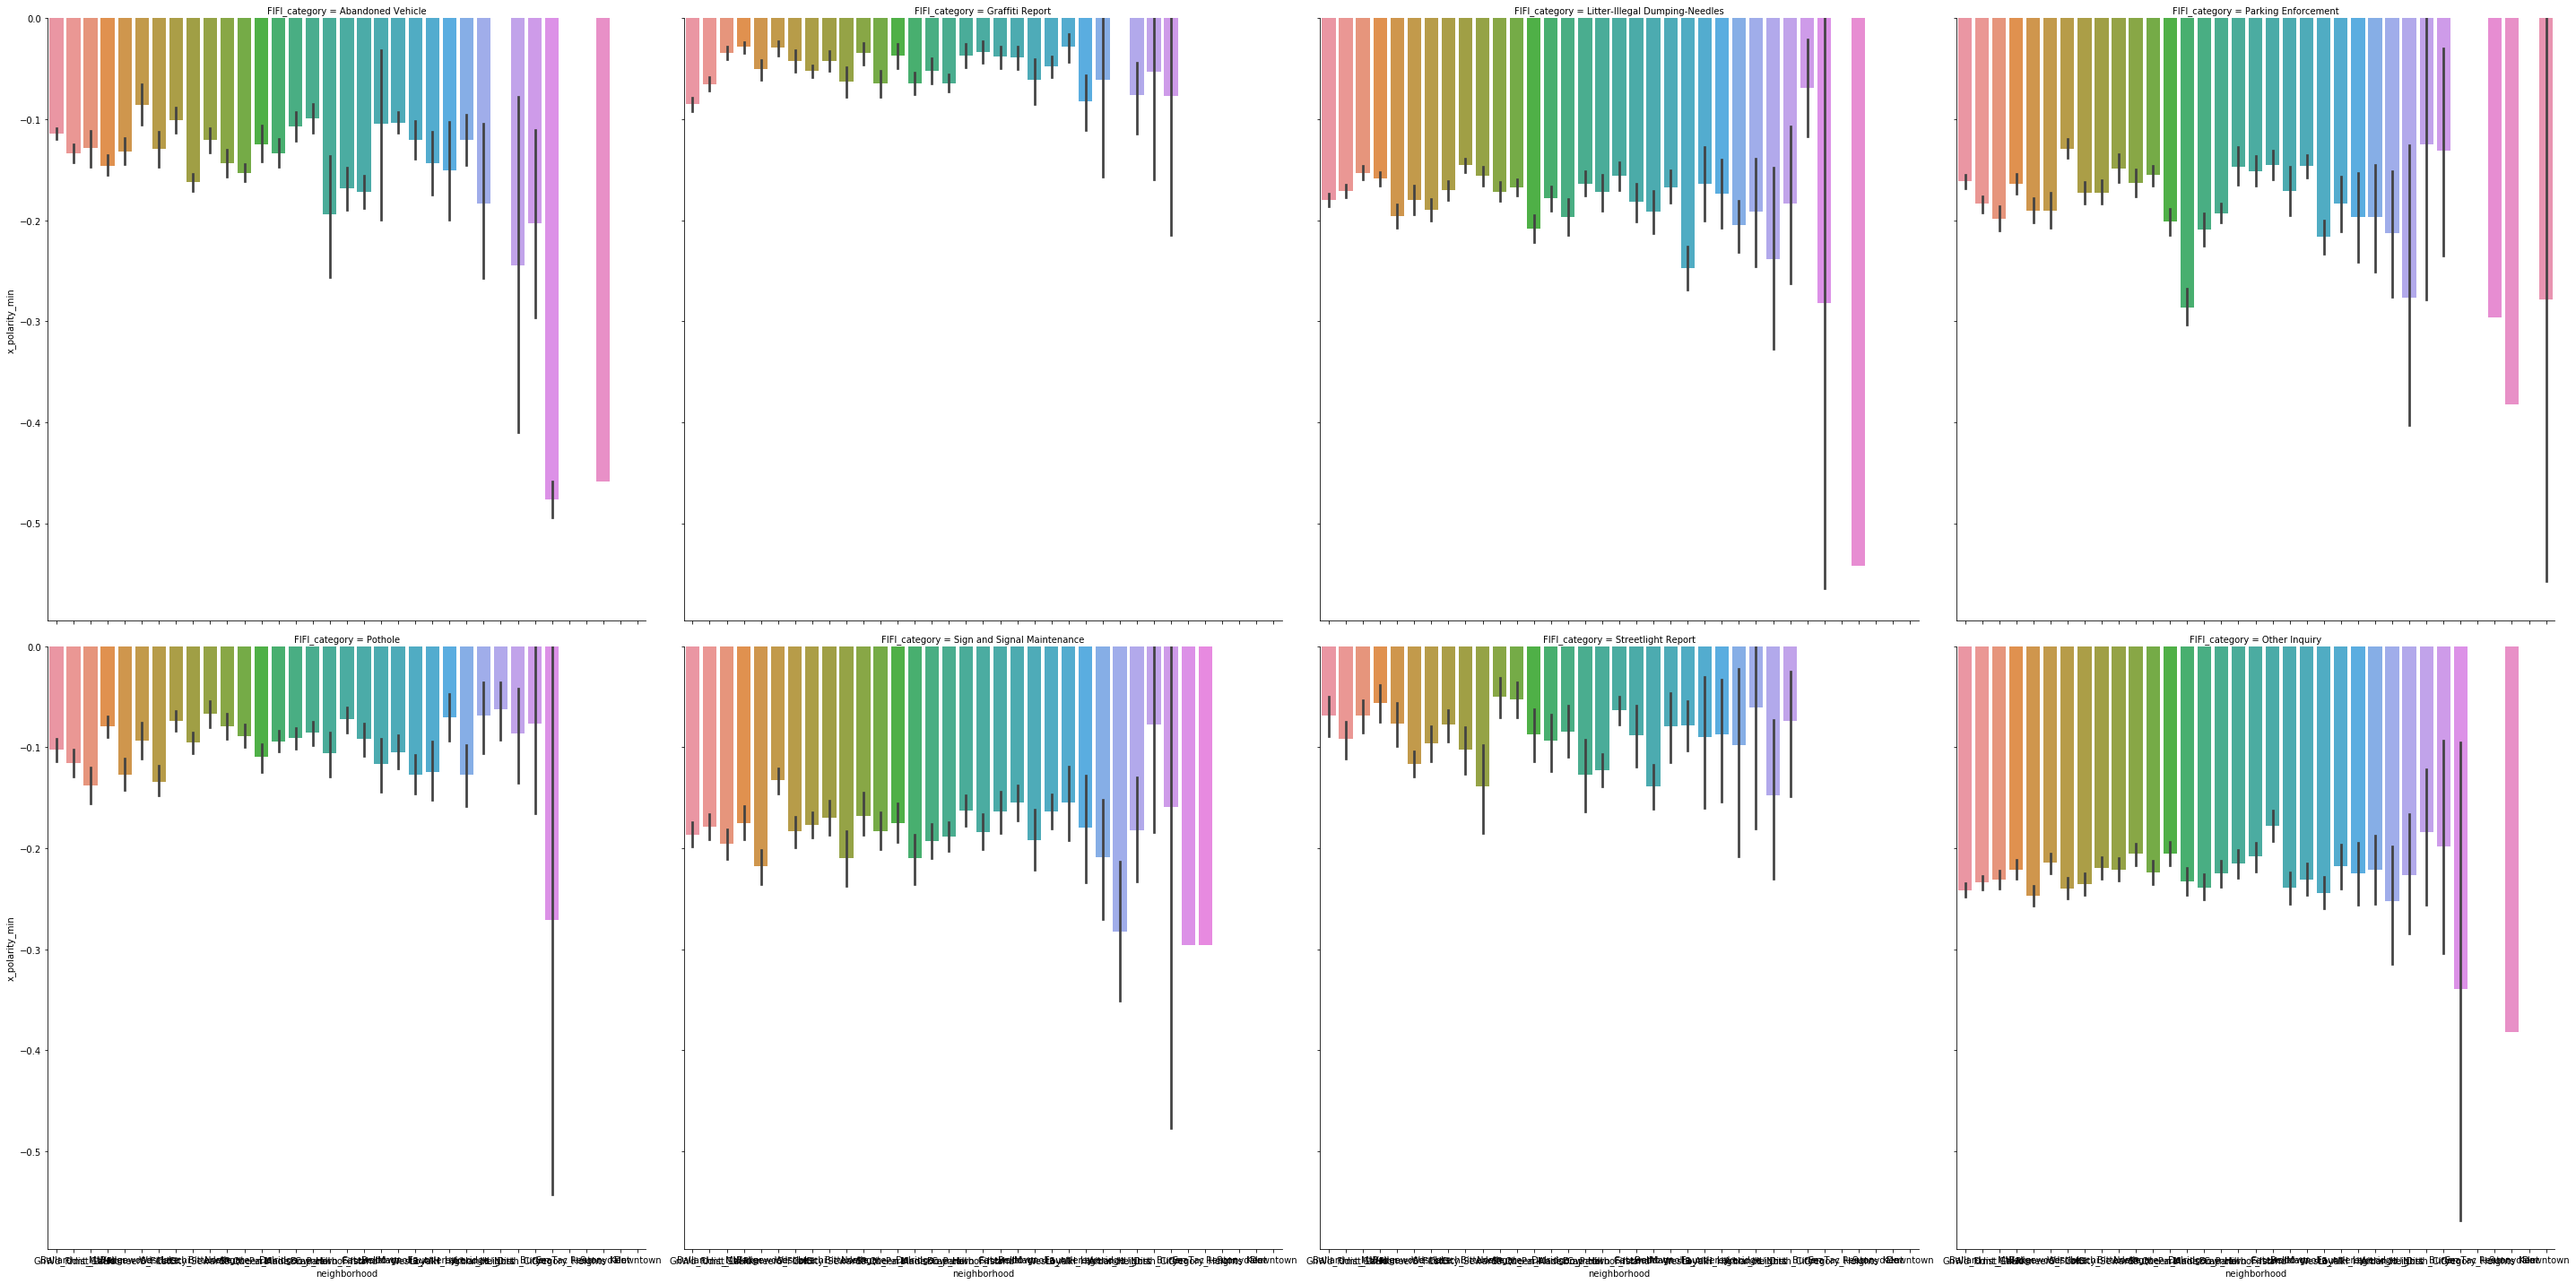

In [214]:
sns.catplot(x='neighborhood', y='x_polarity_min', data=zip_filtered_note, col='FIFI_category', kind='bar', col_wrap=4, height=10, order=other_highest_neigh_list)

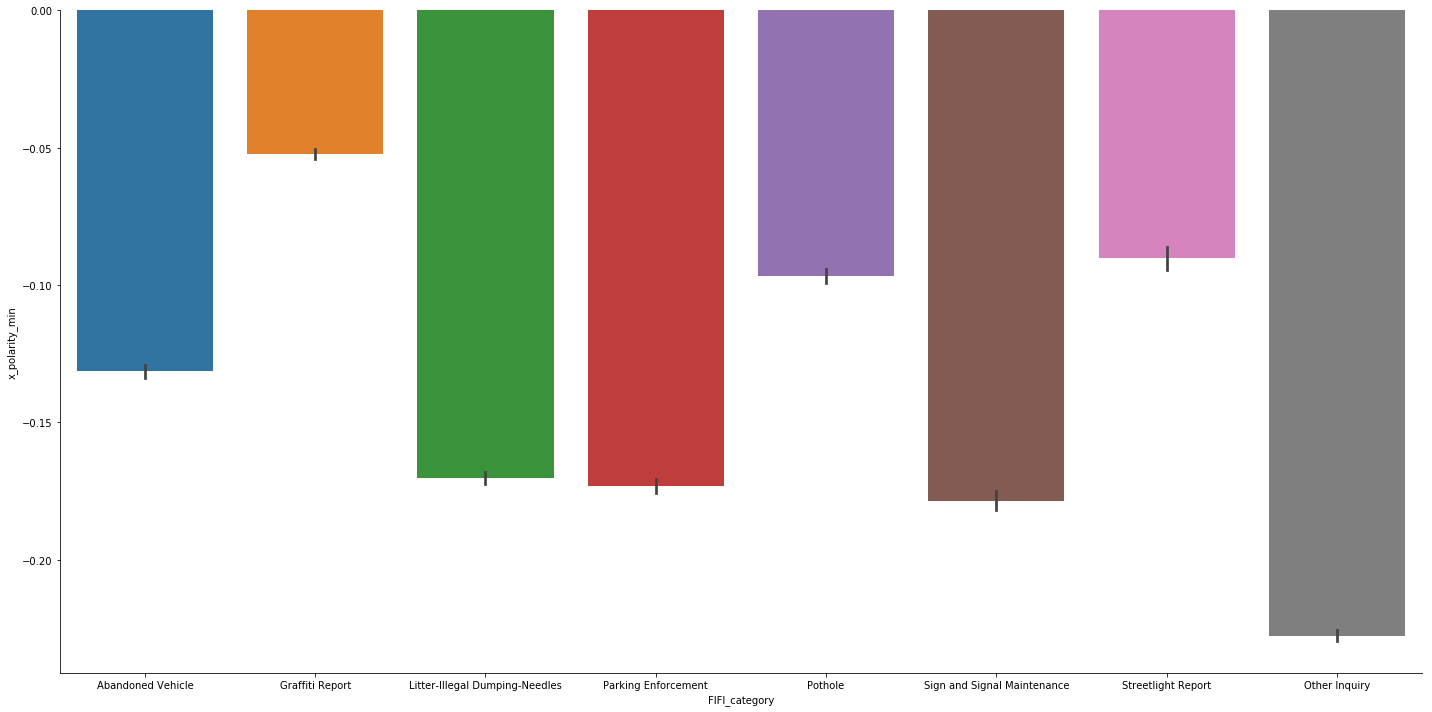

In [235]:
sns.catplot(x='FIFI_category', y='x_polarity_min', data=zip_filtered_note, kind='bar', height=10, aspect=2)